In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


train_data = pd.read_csv('train_test_network.csv')
train_data = pd.DataFrame(train_data)
#print(train_data)

In [4]:
# let's focus on binary labeling for now
train_data = train_data.drop(['type'], axis=1)

In [5]:
# now we want to look if there are any null values in the dataset
print(train_data.isnull().sum())

# as we can see there are no empty cells so we don't need to drop anything 

src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_len    0
http_status_code    

In [6]:
# we need to encode categorical data so then we can use a correlation graph
# to check which features are the most important

# Initialize encoders
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder( drop='first')  # drop='first' to avoid multicollinearity

# Step 1: Encode Binary and Low-Unique Columns with LabelEncoder
binary_columns = ['weird_notice', 'http_version']
low_unique_columns = ['dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_resumed', 'ssl_established']

# Apply LabelEncoder
for col in binary_columns + low_unique_columns:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Step 2: Apply OneHotEncoder to Nominal Columns with More Categories
nominal_columns = ['proto', 'service', 'conn_state', 'ssl_version', 'ssl_cipher', 
                   'http_method', 'http_resp_mime_types', 'label']

# Use ColumnTransformer to apply OneHotEncoder to selected columns
# ColumnTransformer allows for easy application of transformations on subsets of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), nominal_columns)  # drop='first' to avoid multicollinearity
    ],
    remainder='passthrough'  # keep other columns unchanged
)

train_data_transformed = preprocessor.fit_transform(train_data)
# Get feature names for one-hot encoded columns
one_hot_encoded_cols = preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_columns)
# Combine transformed data into a DataFrame with proper column names
final_data = pd.DataFrame(train_data_transformed, columns=list(one_hot_encoded_cols) + list(train_data.drop(columns=nominal_columns).columns))


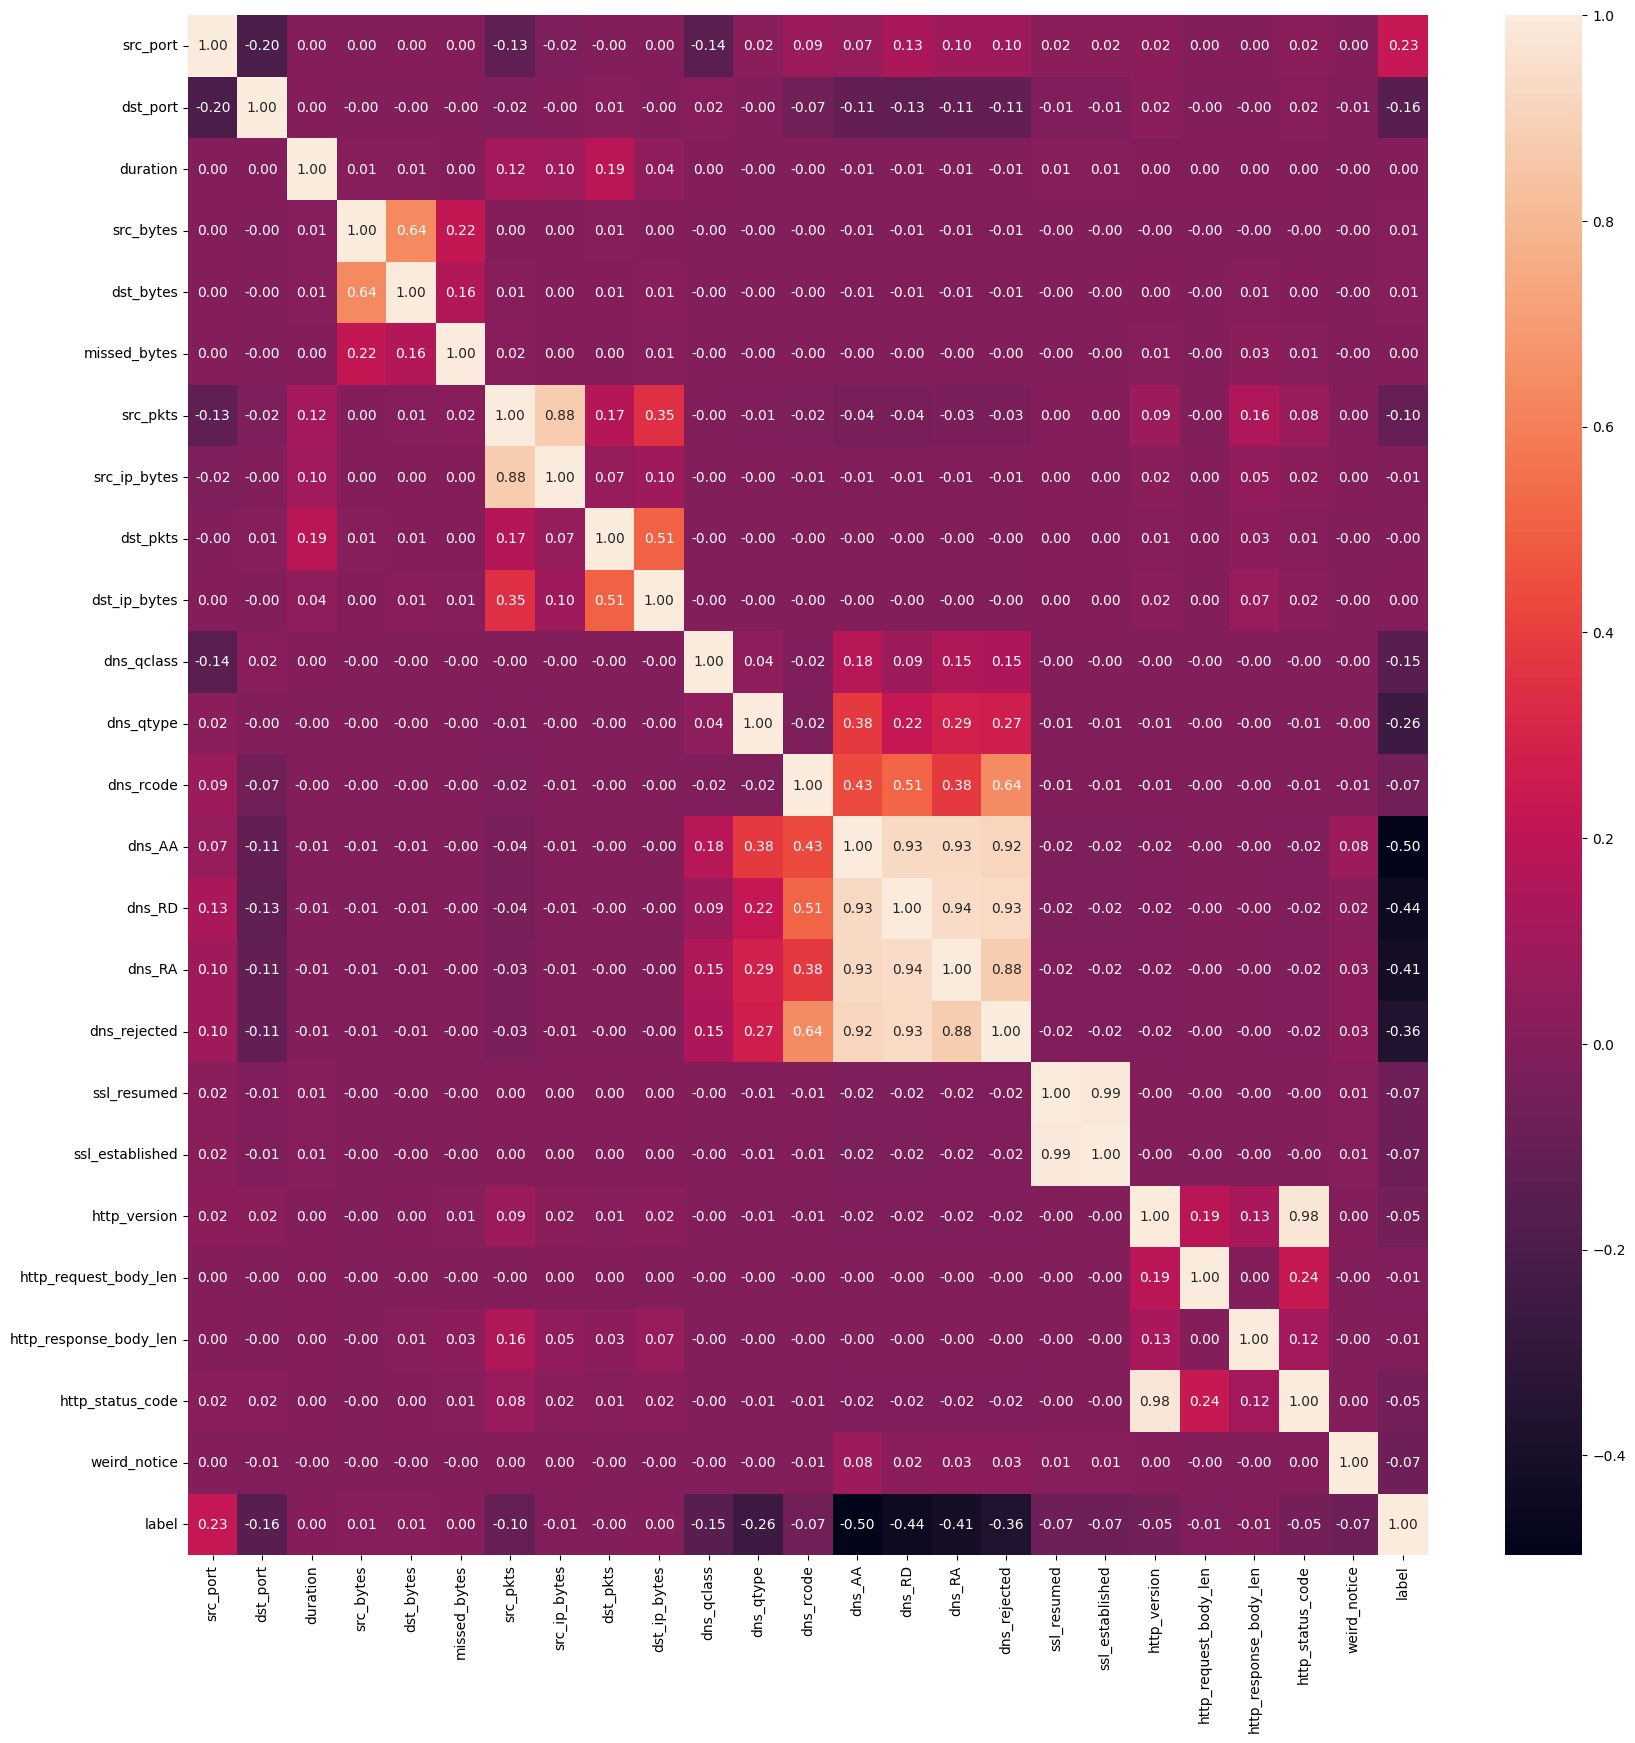

In [7]:
corr = train_data.corr() # it crashes when final_data is being used, but I think it is intended since we append the list at the end?
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

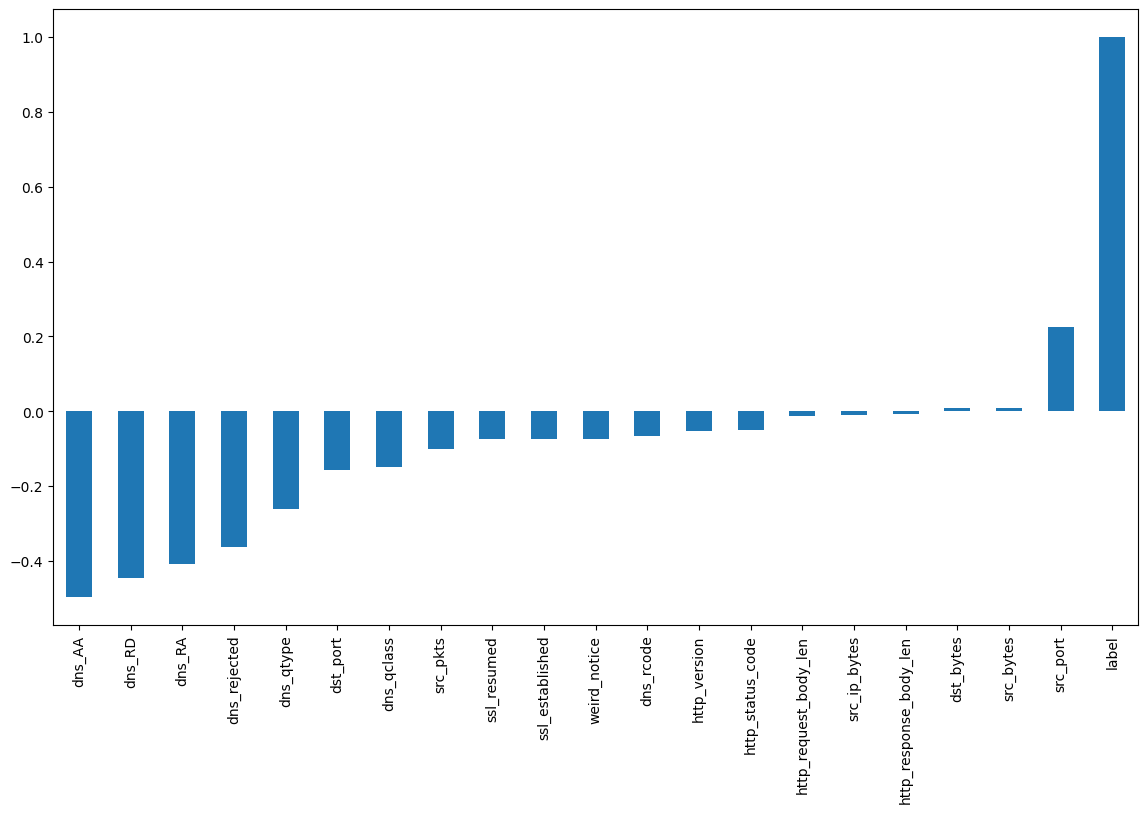

In [8]:
# from what we see duration, missed_bytes, dst_pkts and dst_ip_bytes
# have colleration to label equal to zero so we drop them
train_data = train_data.drop(['duration'], axis=1)
train_data = train_data.drop(['missed_bytes'], axis=1)
train_data = train_data.drop(['dst_pkts'], axis=1)
train_data = train_data.drop(['dst_ip_bytes'], axis=1)

# let's plot which features have the greatest positive and negative colleration with label
correlations = train_data.corr()['label'].sort_values()
plt.figure(figsize=(14, 8))
correlations.plot(kind='bar')
plt.show()

In [9]:
# Check class distribution
print(train_data['label'].value_counts(normalize=True))  # target_column is your label column


1    0.763081
0    0.236919
Name: label, dtype: float64


categorical columns: Index(['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query',
       'dns_rejected', 'http_uri'],
      dtype='object')


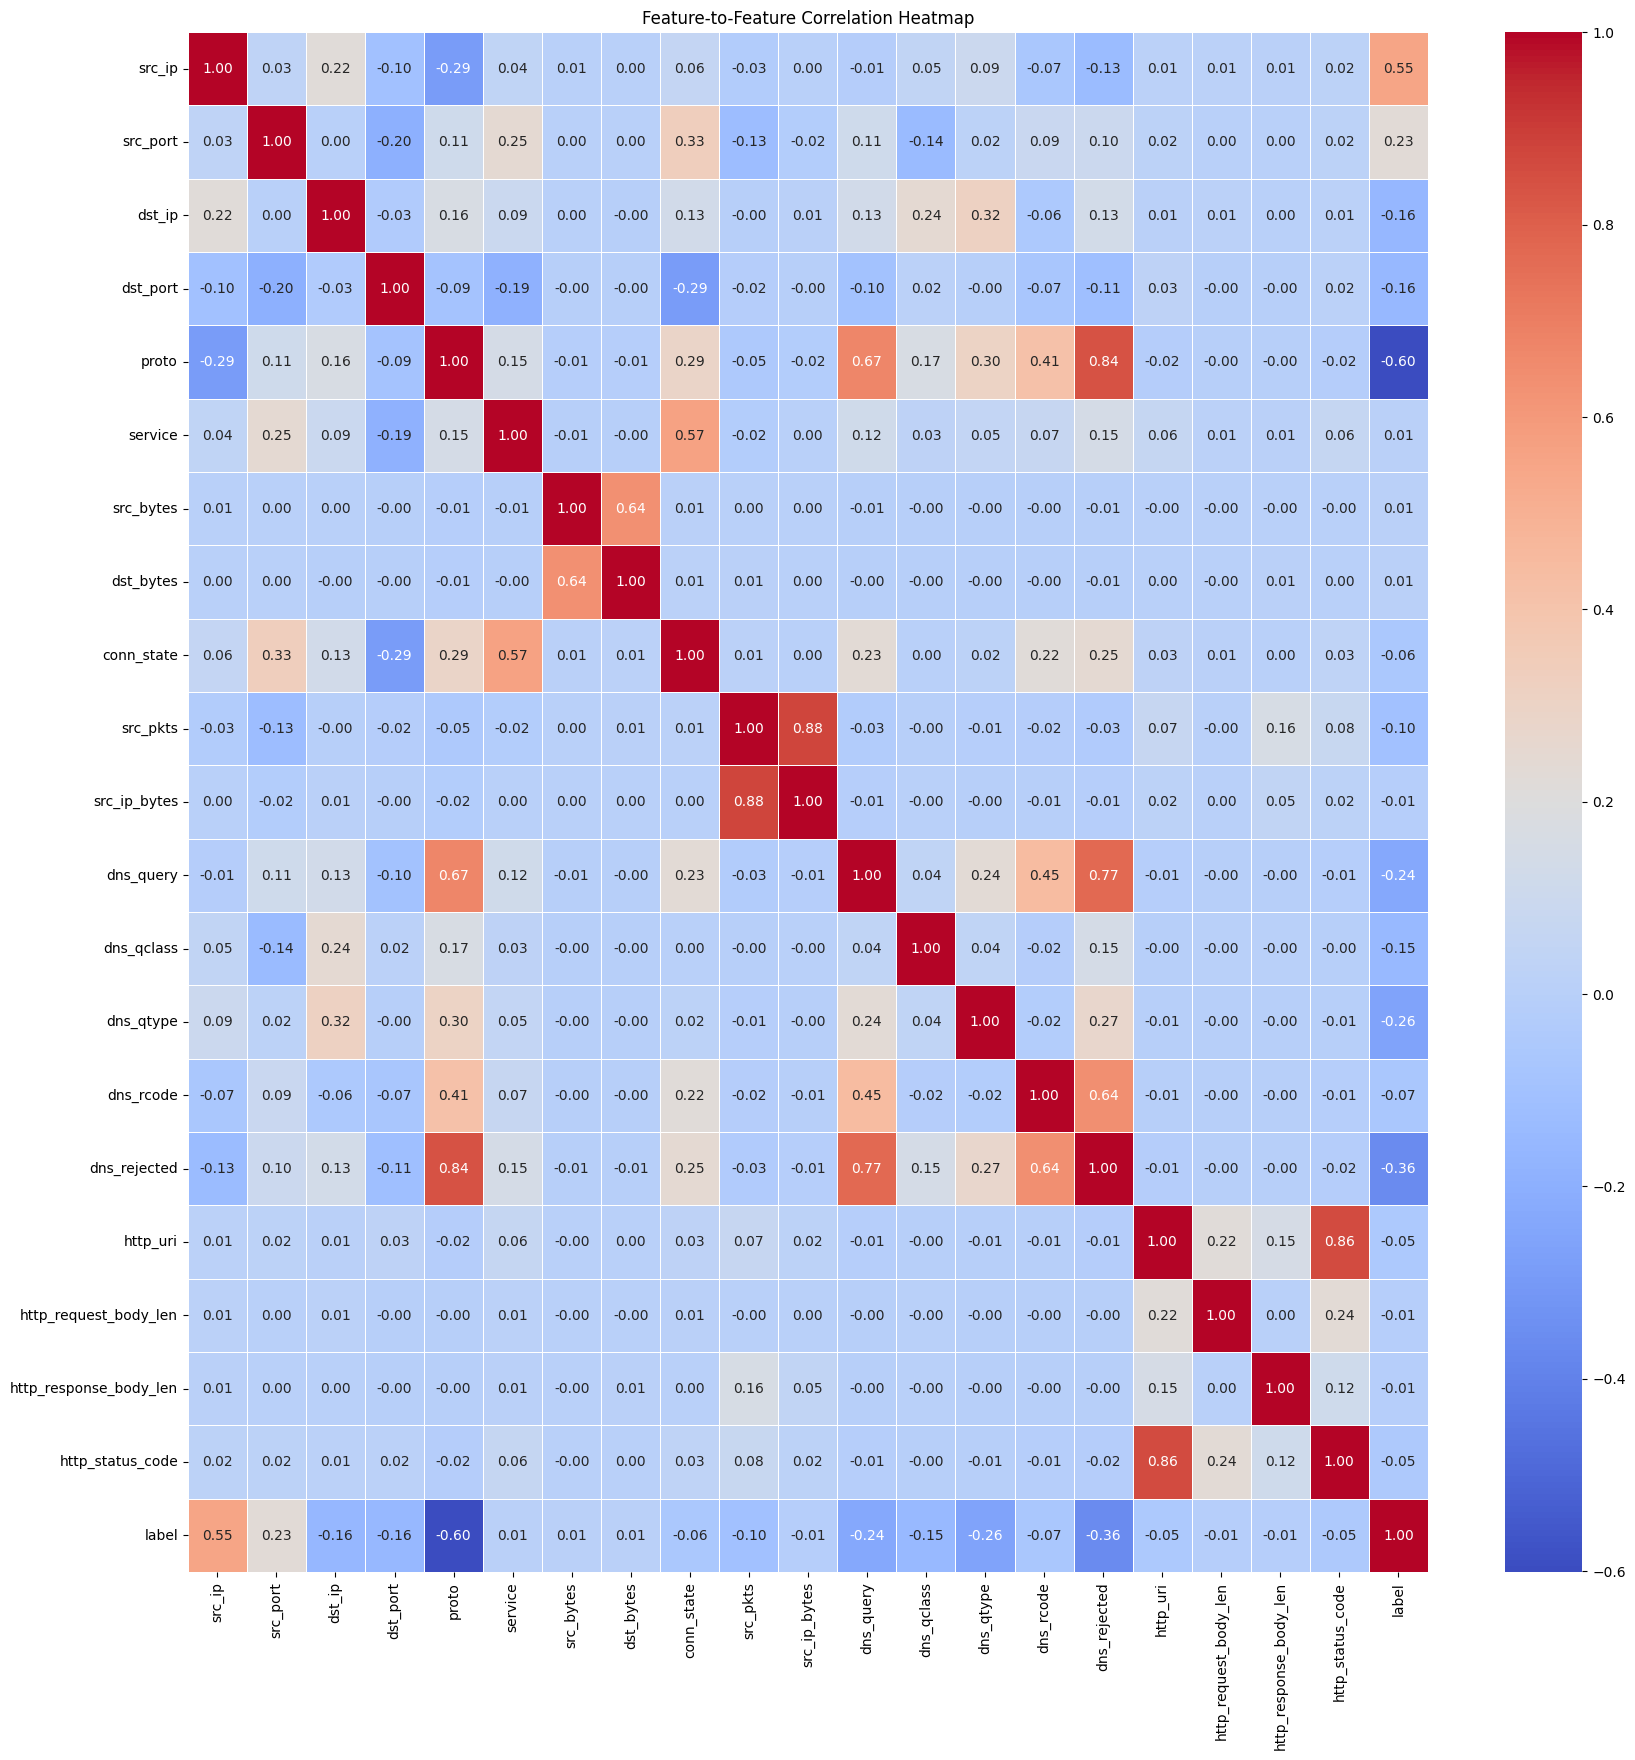

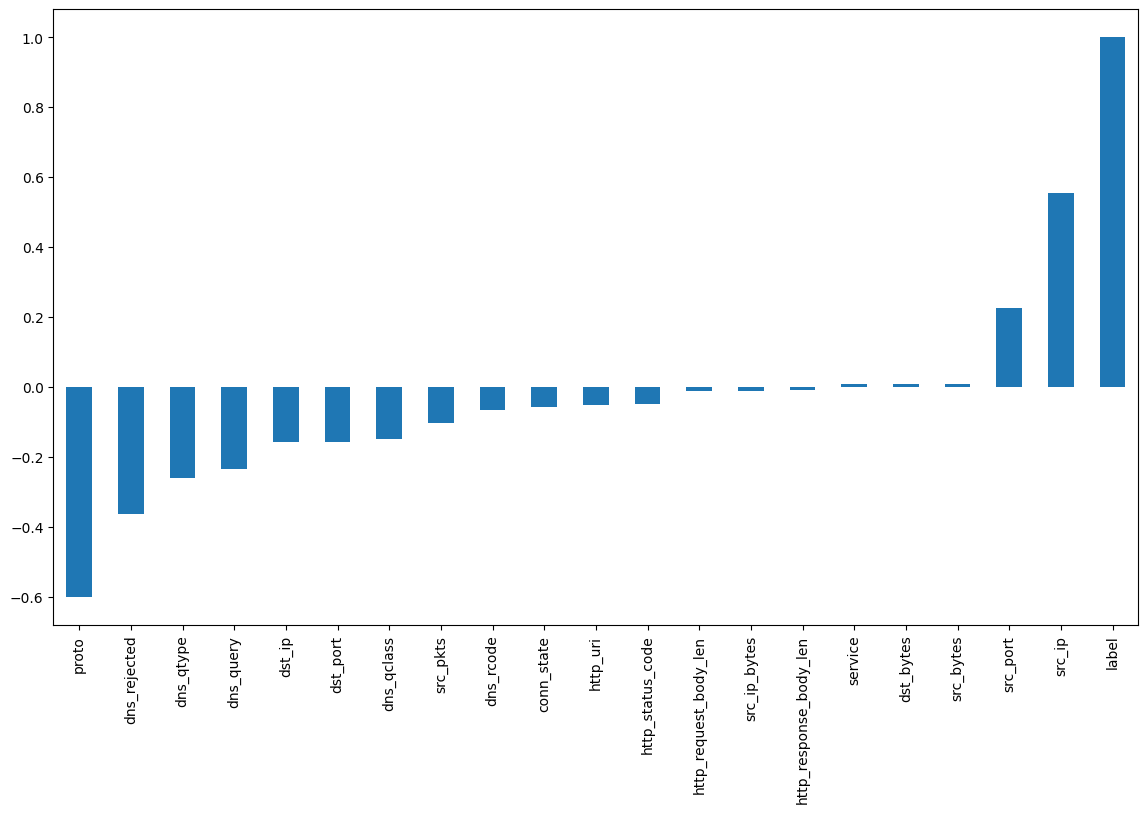

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('train_test_network.csv')
data = pd.DataFrame(data)

columns_to_drop = ['type', 'dst_ip_bytes', 'missed_bytes', 'duration', 'dst_pkts', 
                   'dns_RA', 'dns_AA', 'dns_RD', 'ssl_subject', 'ssl_issuer', 'ssl_version',
                   'ssl_cipher', 'ssl_resumed', 'ssl_established', 'http_trans_depth', 'http_method',
                   'http_version', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types',
                   'weird_name', 'weird_addl', 'weird_notice']
data_cleaned = data.drop(columns=columns_to_drop, axis=1)
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
print(f"categorical columns: {categorical_columns}")

# Apply LabelEncoder to categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))
    label_encoders[col] = le

correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature-to-Feature Correlation Heatmap')
plt.show()

correlations = data_cleaned.corr()['label'].sort_values()
plt.figure(figsize=(14, 8))
correlations.plot(kind='bar')
plt.show()


as we can see the majority of class 1 comprosies about 76% of the data, while minority class 0 only makes about 24%, therefore using SMOTE can be beneficial